## Figure 1: Performance of the $p_0$ perturbative algorithm


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import utils
import response_matrix

In [41]:
# For the distribution, I'm going to use a normal distribution centered at 0000 in the permuted space
# i.e. treat x-values as int_n's that overflow 2^n - 1 -> 0

n = 5
def gaussian(x, x0, sigma):
    return np.exp(-(x - x0)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)

def permuted_nbit_guassian(j, n, sigma):
    """Compute the gaussian centered at n//2 on a bit value `j` that has been shifted by n//2.
    
    This has the effect of centering the gaussian on `0` but maintaining tails symmetrically around
    `000` in both the high- and low-weight subspaces.
    """
    halfpoint = 1 << (n - 1)
    fullrange = 1 << n
    x = ((j + (halfpoint)) % fullrange) / fullrange
    x0 = halfpoint / fullrange
    return gaussian(x, x0, sigma)/ (1 << n)
    
    
def nbit_guassian(j, n, sigma):
    """Compute the asymmetric gaussian centered at 0.
    """
    fullrange = 1 << n
    x = j / fullrange
    x0 = 0
    return gaussian(x, x0, sigma)/ (1 << n)
    
# permuted_nbit_guassian(0, 4, .25)

# gaussian(0, 0, .25)

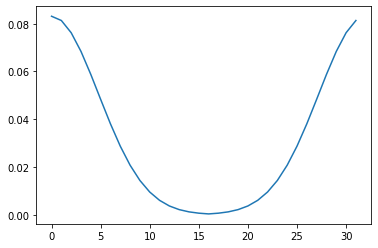

In [25]:
x = np.arange(1 << n)
p0 = permuted_nbit_guassian(x, n, .15) 
plt.plot(x, p0)

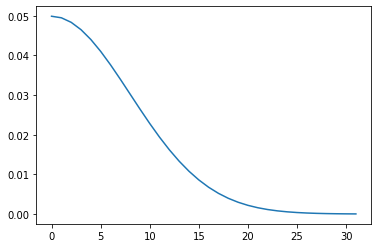

In [40]:
x = np.arange(1 << n)
p0 = nbit_guassian(x, n, .25) / (1 << n)
plt.plot(x, p0)

### Compute the corrected prob distribution using Algorithm 1

### Construct test R

We enforce that $R$ has a tensor structure so that multi-flip events are necessarily exponentially suppressed in weight change of bitstring.

In [28]:

q01_arr = np.asarray([0.09, .07, 0.12, 0.08, 0.11, 0.06, 0.07, 0.11, 0.05, 0.08])
q10_arr = np.asarray([0.04, .03, .05, 0.04, 0.03, .05, .04, 0.06, 0.05, 0.03])
wvals = [1, 2, 3, 4]
nqubits_lst = [4, 6, 8, 10]
R = response_matrix.Rmatrix(q01_arr, q10_arr)
Rinv = np.linalg.inv(R)

## Compute two different corrections

In [47]:
# comparison = lambda x,y: scipy.stats.entropy(x,y)
def rel_err(x, y): return abs(x - y) / x # x is 'truth'
def abs_err(x, y): return abs(x - y)
comparison = rel_err

# Outcomes for correcting p0
p0_baseline = np.zeros(len(nqubits_lst))
p0_outcomes = np.zeros((len(wvals), len(nqubits_lst))) # rows correspond to w=1,2...

for j, n_qubits in enumerate(nqubits_lst):
    # Generate response matrix and artificial readout error
    R = response_matrix.Rmatrix(q01_arr[:n_qubits], q10_arr[:n_qubits])
    Rinv = np.linalg.inv(R)
    x = np.arange(1 << n_qubits)
#     p_true = permuted_nbit_guassian(x, n_qubits, .15)
    p_true = nbit_guassian(x, n_qubits, .25)
    p_prime = R @ p_true
    
    # Just p0 correction
    p0_baseline[j] = comparison(p_true[0], p_prime[0])
    for k, w in enumerate(wvals):
        p0_corr = response_matrix.invert_p0_truncated(R, p_prime, w=w)
        p0_outcomes[k,j] = abs(p_true[0] - p0_corr)
    

## Compute correction on just $p_0$

/home/forky40/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


[[1.52182547e-03 1.78568695e-03 1.21422814e-03 5.28413852e-04]
 [1.91194765e-05 1.10707929e-04 1.49360927e-04 9.13252404e-05]
 [6.27756150e-09 2.90939988e-06 1.01210155e-05 9.53397642e-06]
 [0.00000000e+00 2.37797912e-08 3.76674724e-07 6.29423690e-07]]


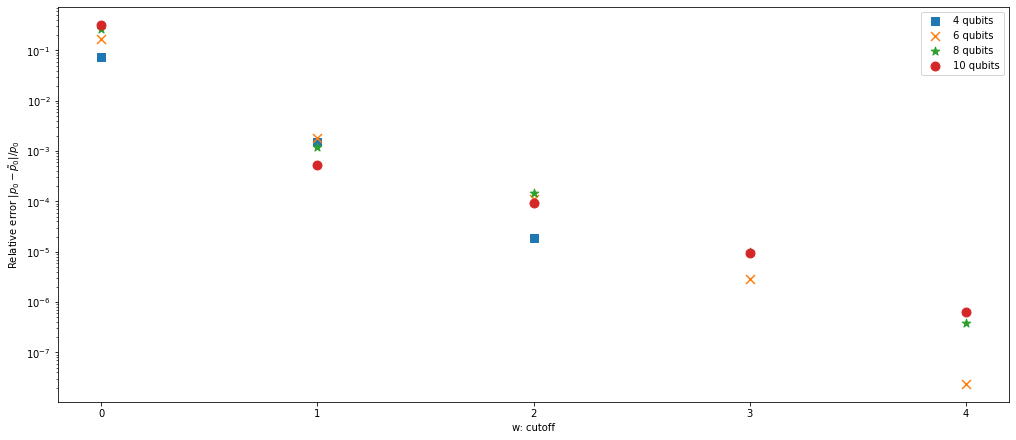

In [52]:
all_p0_outcomes = np.vstack((p0_baseline, p0_outcomes))
x = [0] + wvals
leglabs = [f"{x} qubits" for x in nqubits_lst]
markers = [',', 'x', '*', 'o', '*']

fig, ax = plt.subplots(1, 1, figsize=(14, 6), constrained_layout=True)

# p0 results
for j, y in enumerate(all_p0_outcomes.T):
    ax.scatter(x, y, label=leglabs[j], marker=markers[j], s=80)

ax.set_xlabel("w: cutoff")
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.semilogy()

ax.set_ylim(0, ax.get_ylim()[1])

ax.set_ylabel(r"Relative error $|p_0 - \tilde{p}_0| / p_0$")
ax.legend()
fig.savefig("acc_plot_1.pdf")
print(p0_outcomes)

In [13]:
fig.savefig("figures/figure1.pdf")